In [2]:
import os.path as op
import time
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
import dipy.data as dpd

import nibabel as nib
import dipy.data as dpd
import os
import dipy.data as dpd

from dipy.align import VerbosityLevels
from dipy.align.metrics import CCMetric
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from scipy.ndimage.morphology import binary_dilation
%matplotlib inline


Dataset is already in place. If you want to fetch it again please first remove the folder /home/omar/.dipy/stanford_hardi 
Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/omar/.dipy/mni_template 


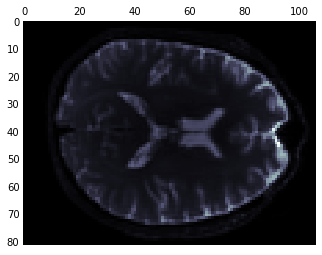

In [3]:
ni, gtab = dpd.read_stanford_hardi()
hardi_data = ni.get_data()
hardi_affine = ni.get_affine()
b0 = hardi_data[..., gtab.b0s_mask]
mean_b0 = np.mean(b0, -1)

ni_b0 = nib.Nifti1Image(mean_b0, hardi_affine)
ni_b0.to_filename('mean_b0.nii')
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)

MNI_T2 = dpd.read_mni_template()
MNI_T2_data = MNI_T2.get_data()
MNI_T2_affine = MNI_T2.get_affine()

Applying zero mask: False
Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
0:	-15835.511011	-15835.511011	-31671.022022	inf
1:	-18198.179413	-18198.179413	-36396.358826	inf
2:	-20946.903102	-20946.903102	-41893.806204	inf
3:	-23332.231226	-23332.231226	-46664.462451	inf
4:	-25304.962263	-25304.962263	-50609.924526	inf
5:	-27063.440782	-27063.440782	-54126.881564	inf
6:	-28680.128293	-28680.128293	-57360.256585	inf
7:	-29921.511603	-29921.511603	-59843.023206	inf
8:	-31001.352484	-31001.352484	-62002.704969	inf
9:	-32266.930066	-32266.930066	-64533.860132	inf
Optimizing level 1
0:	-202743.526123	-202743.526123	-405487.052246	inf
1:	-212651.513303	-212651.513303	-425303.026605	inf
2:	-224013.963328	-224013.963328	-448027.926655	inf
3:	-233698.502509	-233698.502509	-467397.005018	inf
4:	-242170.710761	-242170.710761	-484341.421522	inf
5:	-249969.038853	-249969.03

/home/omar/opt/dipy/dipy/align/imwarp.py:441: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  W = None if image_world2grid == 'identity' else image_world2grid
/home/omar/opt/dipy/dipy/align/imwarp.py:444: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  S = None if out_grid2world == 'identity' else out_grid2world


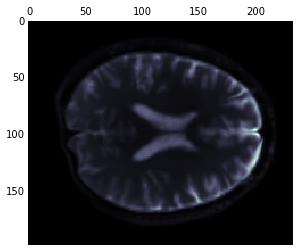

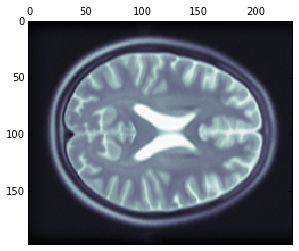

In [4]:
level_iters = [10, 10, 5]
dim = 3
metric = CCMetric(dim)
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, step_length=0.25)
sdr.verbosity = VerbosityLevels.DIAGNOSE
mapping = sdr.optimize(MNI_T2_data, mean_b0, MNI_T2_affine, hardi_affine)
warped_b0 = mapping.transform(mean_b0)
plt.matshow(warped_b0[:,:,warped_b0.shape[-1]//2], cmap=cm.bone)
plt.matshow(MNI_T2_data[:, :, MNI_T2_data.shape[-1]//2], cmap=cm.bone)

new_ni = nib.Nifti1Image(warped_b0, MNI_T2_affine)
new_ni.to_filename('./warped_b0.nii.gz')

In [11]:
afqpath = '/home/omar/opt/AFQ/'
LOCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/L_Occipital.nii.gz'))
ROCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/R_Occipital.nii.gz'))
midsag_ni = nib.load(os.path.join(afqpath,'templates/callosum2/Callosum_midsag.nii.gz'))
LOCC_data = LOCC_ni.get_data()
ROCC_data = ROCC_ni.get_data()
midsag_data = midsag_ni.get_data()

midsag_affine = midsag_ni.get_affine()
midsag_data = midsag_ni.get_data()
warped_midsag = mapping.transform_inverse(midsag_data)

# Dilate along the x axis
structure = np.zeros((3,3,3))
structure[:3,1,1] = 1
dilated = binary_dilation(midsag_data, structure)

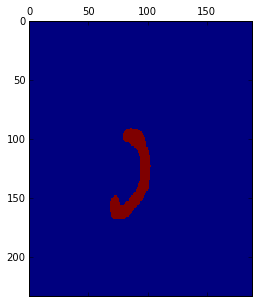

In [14]:
warped_midsag = mapping.transform_inverse(dilated)
im = np.sum(np.ceil(dilated), axis=0)
plt.matshow(im)